In [197]:
import cv2
import pandas as pd
import numpy as np
import csv
import platform
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import data
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# sns.set_style("whitegrid", {'axes.grid' : False})

## Behavioral Cloning
This notebook will mainly be used for creating plots and different visualizatons for the write-up.

In [170]:
folder_path = '/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/training_video_log/driving_log.csv'
proj_path = '/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/'

In [171]:
## read in the training data and split into train and validation    
train_observations, validation_observations = data.read_input(folder_path)

In [172]:
## turning data into a dataframe for easy manipulation
train_df = pd.DataFrame(train_observations)

In [174]:
## print details about the data
print("Number of Training Examples: "+str(len(train_observations)))
print("Number of Validation Examples: "+str(len(validation_observations)))

Number of Training Examples: 7986
Number of Validation Examples: 1997


Below is the original steering angle distribution of the data before any augmentation.

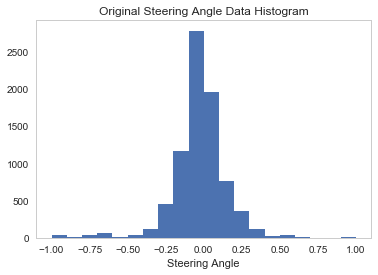

In [201]:
plt.hist(np.asarray(train_df[3], dtype='float'), bins=20)
plt.title("Original Steering Angle Data Histogram")
plt.xlabel("Steering Angle")

## save image for write up
plt.savefig("/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/media/original_distribution.png")
plt.show()

In [6]:
cv2.imread(train_observations[1][1]).shape

(160, 320, 3)

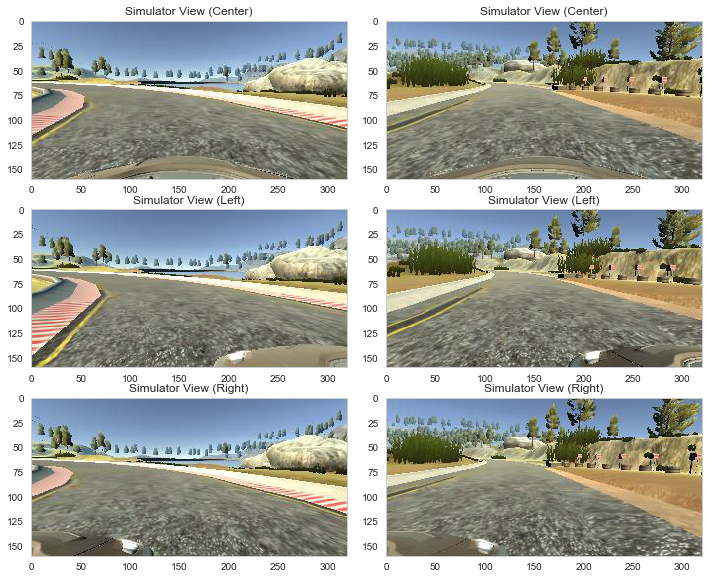

In [202]:
## plot the images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 8))
f.tight_layout()

ax1.imshow(cv2.cvtColor(cv2.imread(train_observations[100][0])[:,:],cv2.COLOR_BGR2RGB))
ax1.set_title('Simulator View (Center)', fontsize=12)

ax2.imshow(cv2.cvtColor(cv2.imread(train_observations[60][0])[:,:],cv2.COLOR_BGR2RGB))
ax2.set_title('Simulator View (Center)', fontsize=12)

ax3.imshow(cv2.cvtColor(cv2.imread(train_observations[100][1])[:,:],cv2.COLOR_BGR2RGB))
ax3.set_title('Simulator View (Left)', fontsize=12)

ax4.imshow(cv2.cvtColor(cv2.imread(train_observations[60][1])[:,:],cv2.COLOR_BGR2RGB))
ax4.set_title('Simulator View (Left)', fontsize=12)

ax5.imshow(cv2.cvtColor(cv2.imread(train_observations[100][2])[:,:],cv2.COLOR_BGR2RGB))
ax5.set_title('Simulator View (Right)', fontsize=12)

ax6.imshow(cv2.cvtColor(cv2.imread(train_observations[60][2])[:,:],cv2.COLOR_BGR2RGB))
ax6.set_title('Simulator View (Right)', fontsize=12)

## save image for write up
# plt.savefig("/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/media/original_simulator_image.png")

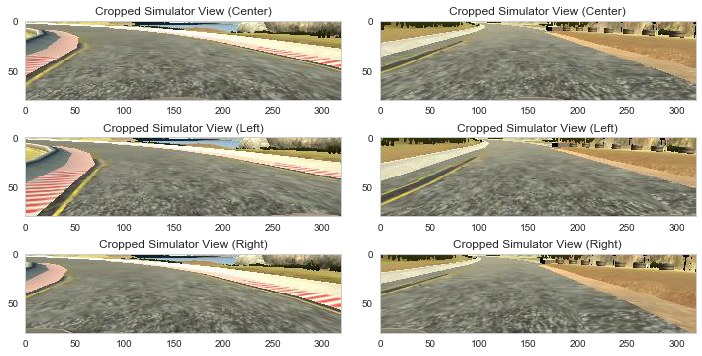

In [196]:
## plot the images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 5))
f.tight_layout()

ax1.imshow(cv2.cvtColor(cv2.imread(train_observations[100][0])[60:140,:],cv2.COLOR_BGR2RGB))
ax1.set_title('Cropped Simulator View (Center)', fontsize=12)

ax2.imshow(cv2.cvtColor(cv2.imread(train_observations[60][0])[60:140,:],cv2.COLOR_BGR2RGB))
ax2.set_title('Cropped Simulator View (Center)', fontsize=12)

ax3.imshow(cv2.cvtColor(cv2.imread(train_observations[100][1])[60:140,:],cv2.COLOR_BGR2RGB))
ax3.set_title('Cropped Simulator View (Left)', fontsize=12)

ax4.imshow(cv2.cvtColor(cv2.imread(train_observations[60][1])[60:140,:],cv2.COLOR_BGR2RGB))
ax4.set_title('Cropped Simulator View (Left)', fontsize=12)

ax5.imshow(cv2.cvtColor(cv2.imread(train_observations[100][2])[60:140,:],cv2.COLOR_BGR2RGB))
ax5.set_title('Cropped Simulator View (Right)', fontsize=12)

ax6.imshow(cv2.cvtColor(cv2.imread(train_observations[60][2])[60:140,:],cv2.COLOR_BGR2RGB))
ax6.set_title('Cropped Simulator View (Right)', fontsize=12)

## save image for write up
plt.savefig("/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/media/cropped_simulator_image.png")

Eventual functions that are used for the data augmentation and for generating the data as batches for the Keras model.

In [157]:
## convert color of the input image to YUV as mentioned in nvidia paper
def preprocess_image(img, color_conversion=cv2.COLOR_BGR2YUV):
    converted_img = cv2.cvtColor(img,color_conversion)
    cropped_img = converted_img[60:140,:,:]

    return cropped_img

def distribute_data(observations, min_needed=500, max_needed=750):
    
    observations_output = observations.copy()
    
    ## create histogram to know what needs to be added
    steering_angles = np.asarray(observations_output[:,3], dtype='float')
    num_hist, idx_hist = np.histogram(steering_angles, 20)
    
    to_be_added = np.empty([1,7])
    to_be_deleted = np.empty([1,1])
    
    for i in range(1, len(num_hist)):
        if num_hist[i-1]<min_needed:

            ## find the index where values fall within the range 
            match_idx = np.where((steering_angles>=idx_hist[i-1]) & (steering_angles<idx_hist[i]))[0]

            ## randomly choose up to the minimum needed
            need_to_add = observations_output[np.random.choice(match_idx,min_needed-num_hist[i-1]),:]
            
            to_be_added = np.vstack((to_be_added, need_to_add))

        elif num_hist[i-1]>max_needed:
            
            ## find the index where values fall within the range 
            match_idx = np.where((steering_angles>=idx_hist[i-1]) & (steering_angles<idx_hist[i]))[0]
            
            ## randomly choose up to the minimum needed
            to_be_deleted = np.append(to_be_deleted, np.random.choice(match_idx,num_hist[i-1]-max_needed))
            
    observations_output = np.delete(observations_output, to_be_deleted, 0)
    observations_output = np.vstack((observations_output, to_be_added[1:,:]))
    
    return observations_output

def generate_data(observations, batch_size=128):

    steering_correction = 0.2 ## applying correction to left and right steering angles
    
    ## set up generator
    while True:
        for offset in range(0, len(observations), batch_size):
            batch_obs = shuffle(observations[offset:offset+batch_size])

            center_images = []
            left_images = []
            right_images = []

            steering_angle_center = []
            steering_angle_left = []
            steering_angle_right = []

            ## loop through lines and append images path/ steering data to new lists
            for observation in batch_obs:

                center_image_path = proj_path + 'training_video_log/IMG/'+observation[0].split('/')[-1]
                left_image_path = proj_path + 'training_video_log/IMG/'+observation[1].split('/')[-1]
                right_image_path = proj_path + 'training_video_log/IMG/'+observation[2].split('/')[-1]

                center_images.append(preprocess_image(cv2.imread(center_image_path)))
                steering_angle_center.append(float(observation[3]))

                left_images.append(preprocess_image(cv2.imread(left_image_path)))
                right_images.append(preprocess_image(cv2.imread(right_image_path)))

                ## append the steering angles and correct for left/right images
                steering_angle_left.append(float(observation[3]) + steering_correction)
                steering_angle_right.append(float(observation[3]) - steering_correction)

            images = center_images + left_images + right_images
            steering_angles = steering_angle_center + steering_angle_left + steering_angle_right

            X = np.array(images)
            y = np.array(steering_angles)

            yield shuffle(X, y)


In [158]:
augmented_data = distribute_data(np.array(train_observations))

/Users/Jeffwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


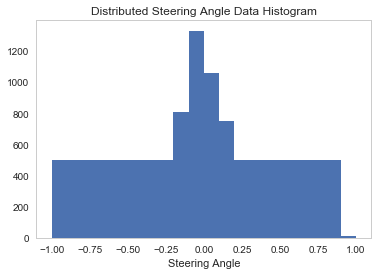

In [203]:
plt.hist(np.asarray(augmented_data[:,3], dtype='float'), bins=20)
plt.title("Distributed Steering Angle Data Histogram")
plt.xlabel("Steering Angle")

## save image for write up
# plt.savefig("/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/media/augmented_distribution.png")
plt.show()

I also considered including the udacity dataset, but felt like I already had enough data to work with.

In [28]:
udacity_data = pd.read_csv("/Users/Jeffwen/Documents/Online Courses/sdcnd_behavioral_cloning/data/driving_log.csv")

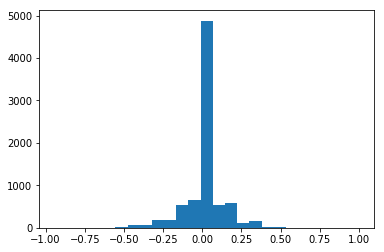

In [33]:
plt.hist(np.asarray(udacity_data['steering'], dtype='float'), bins=25)
plt.show()